In [24]:
import numpy as np

import scipy as sp
import scipy.sparse
import scipy.sparse.linalg

import sklearn
import sklearn.preprocessing

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import networkx as nx

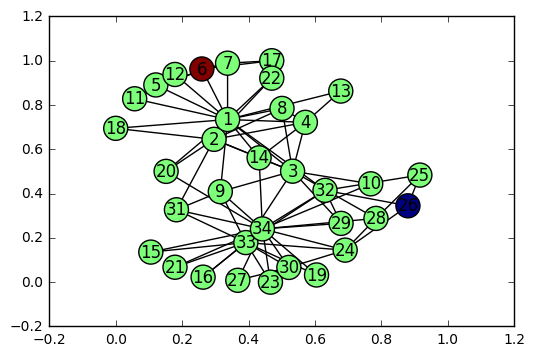

In [41]:
# karate network dataset

kn = nx.read_gml("karate.gml")
A = nx.adjacency_matrix(kn).todense()
nodes = [int(i) for i in kn.nodes()]
d = np.zeros(34)
d[nodes.index(6)] = 1
d[nodes.index(26)] = -1


nx.draw_networkx(kn, node_color=d)

In [42]:
# preprocessing

F = sklearn.preprocessing.normalize(A, axis=1, norm='l1')
B = sklearn.preprocessing.normalize(A.T, axis=1, norm='l1')

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


In [43]:
a1 = 0.7
a2 = 0.7
a3 = 0.7

In [44]:
# we are looking for solution x == T(x)

def T(x):
    return a1 * F.dot(x.clip(0)) + a2 * B.dot(x.clip(-np.inf, 0)) + a3 * d

In [45]:
# RepRank

def RepRank(maxiter=200, x0=None, tol=1e-8, callback=None):
    if x0 is None:
        x_prev = d.copy()
    else:
        x_prev = x0.copy()

    for k in range(maxiter):
        x_next = T(x_prev)
        n = np.linalg.norm(x_next - x_prev)
        if callback is not None:
            callback(x_next, n)
        if n < tol:
            break
        x_prev = x_next

    ans = x_next.copy()
    return(k + 1, ans.reshape(-1,))

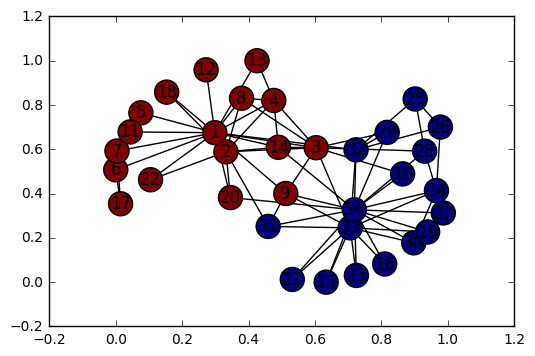

In [46]:
k, ans = RepRank()

ans[ans > 0] = 1
ans[ans < 0] = -1

nx.draw_networkx(kn, node_color=ans)

In [32]:
def h(x):
    ans = np.zeros_like(x)
    ans[x > 0.0] = 1.0
    return ans

In [33]:
def obj(x):
    return np.linalg.norm(x - T(x)) ** 2 / 2

In [34]:
def Jac(x):
    return np.eye(F.shape[0]) - a1 * np.multiply(F, h(x).reshape(-1, 1)) - a2 * np.multiply(B, h(-x).reshape(-1, 1))

In [35]:
def der(x):
    l = x - T(x)
    return Jac(x).T.dot(l)

In [36]:
def Hess(x):
    return Jac(x).T.dot(Jac(x))

In [12]:
def LineSearch(x, dx):
    alpha = obj(x) / np.linalg.norm(dx) ** 2
    while True:
        if obj(x + alpha * dx) < obj(x):
            return x + alpha * dx
        else:
            alpha /= 2

In [37]:
x_prev = d.copy()
x_next = x_prev.copy()

for k in range(100):
    dx = der(x_prev)
    #x_next = LineSearch(x_prev, -dx)
    x_next = x_prev - dx * obj(x_prev) / np.linalg.norm(dx) ** 2
    if obj(x_next) < 1e-8:
        break
    x_prev = x_next.copy()

print(k)

74


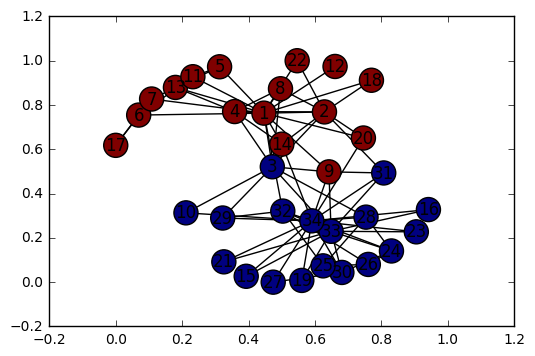

In [38]:
ans = x_prev.copy()
ans[x_prev > 0] = 1
ans[x_prev < 0] = -1

nx.draw_networkx(kn, node_color=ans)

In [39]:
x_prev = d.copy()
x_next = x_prev.copy()

for k in range(100):
    dx = np.linalg.solve(Hess(x_prev), -der(x_prev))
    x_next = x_prev + dx
    if obj(x_next) < 1e-8:
        break
    print(k, obj(x_next))
    x_prev = x_next.copy()

0 0.0284364502781
1 0.00416541912519


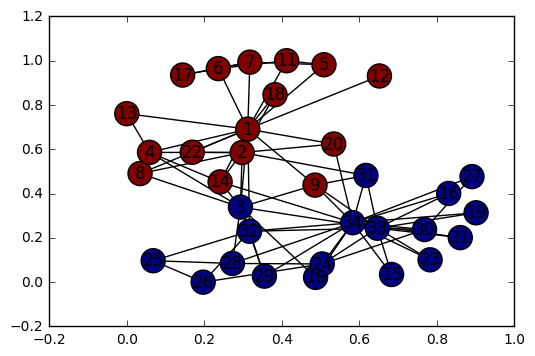

In [40]:
ans = x_prev.copy()
ans[x_prev > 0] = 1
ans[x_prev < 0] = -1

nx.draw_networkx(kn, node_color=ans)